<a href="https://colab.research.google.com/github/danielabebe1/Capstone2/blob/master/Pulmonary_Fibrosis_continuation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#https://www.raddq.com/dicom-processing-segmentation-visualization-in-python/
#https://medium.com/@hengloose/a-comprehensive-starter-guide-to-visualizing-and-analyzing-dicom-images-in-python-7a8430fcb7ed 

!pip install pydicom
import os
from os import listdir
import pandas as pd
import numpy as np
import glob
import tqdm
from typing import Dict
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import pydicom as dicom 
import warnings
warnings.filterwarnings('ignore')
plt.show()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install colorama
#Directories
image_train='/content/drive/My Drive/OSIC Pulmonary Fibrosis/training/'
image_test='/content/drive/My Drive/OSIC Pulmonary Fibrosis/testing/'
train_csv='/content/drive/My Drive/OSIC Pulmonary Fibrosis/train.csv'
test_csv='/content/drive/My Drive/OSIC Pulmonary Fibrosis/test.csv'
sub_csv='/content/drive/My Drive/OSIC Pulmonary Fibrosis/sample_submission.csv'
#read csv
df_train=pd.read_csv(train_csv)
df_test=pd.read_csv(test_csv)
df_sub=pd.read_csv(sub_csv)
df_sub['Weeks']   = df_sub['Patient_Week'].apply( lambda x: int(x.split('_')[-1]) )
df_sub['Patient'] = df_sub['Patient_Week'].apply( lambda x: x.split('_')[0] )

In [4]:
#creating path column for dcm files of patient
df_train['Path']=image_train + df_train['Patient']
df_train['dcm count']=0
for i, path in enumerate(df_train['Path']):
  df_train['dcm count'][i]=len(os.listdir(path))

In [5]:
# Load the scans in given folder path
def load_scan(image_train):
    slices = [dicom.read_file(image_train + '/' + s) for s in os.listdir(image_train)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation) 
    for s in slices:
        s.SliceThickness = slice_thickness 
    return slices

In [6]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)
    image[image == -2000] = 0
    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
        image[slice_number] += np.int16(intercept)
    return np.array(image, dtype=np.int16)

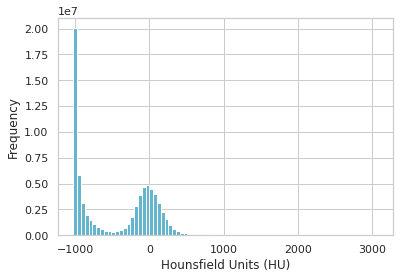

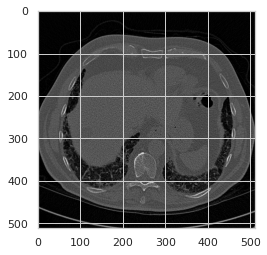

In [7]:
patients = os.listdir(image_train)
first_patient = load_scan(image_train + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(first_patient_pixels[0], cmap=plt.cm.gray)
plt.show()

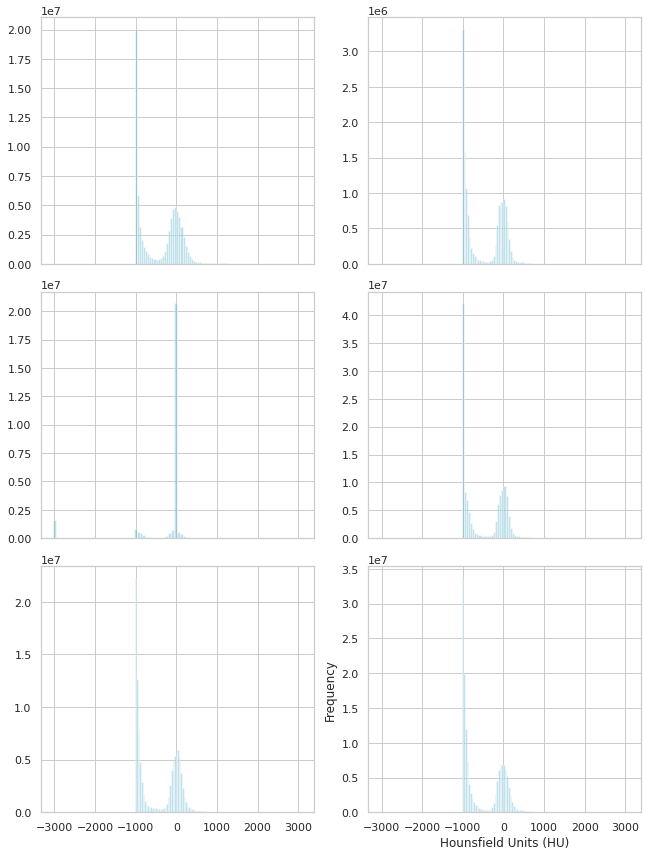

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
f, axes = plt.subplots(3, 2,figsize=(9, 12), sharex=True)
first_patient = load_scan(image_train + patients[0])
second_patient = load_scan(image_train + patients[1])
third_patient = load_scan(image_train + patients[2])
forth_patient = load_scan(image_train + patients[3])
fifth_patient = load_scan(image_train + patients[4])
sixth_patient = load_scan(image_train + patients[5])
first_patient_pixels = get_pixels_hu(first_patient)
second_patient_pixels = get_pixels_hu(second_patient)
third_patient_pixels = get_pixels_hu(third_patient)
forth_patient_pixels = get_pixels_hu(forth_patient)
fifth_patien_pixels = get_pixels_hu(fifth_patient)
sixth_patient_pixels = get_pixels_hu(sixth_patient)
sns.distplot(first_patient_pixels.flatten(), bins=80, kde = False,ax=axes[0,0],color='c')
sns.distplot(second_patient_pixels.flatten(), bins=80, kde = False,ax=axes[0,1],color='c')
sns.distplot(third_patient_pixels.flatten(), bins=80, kde = False,ax=axes[1,0],color='c')
sns.distplot(forth_patient_pixels.flatten(), bins=80, kde = False,ax=axes[1,1],color='c')
sns.distplot(fifth_patien_pixels.flatten(), bins=80, kde = False,ax=axes[2,0],color='c')
sns.distplot(sixth_patient_pixels.flatten(), bins=80, kde = False,ax=axes[2,1],color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.tight_layout()

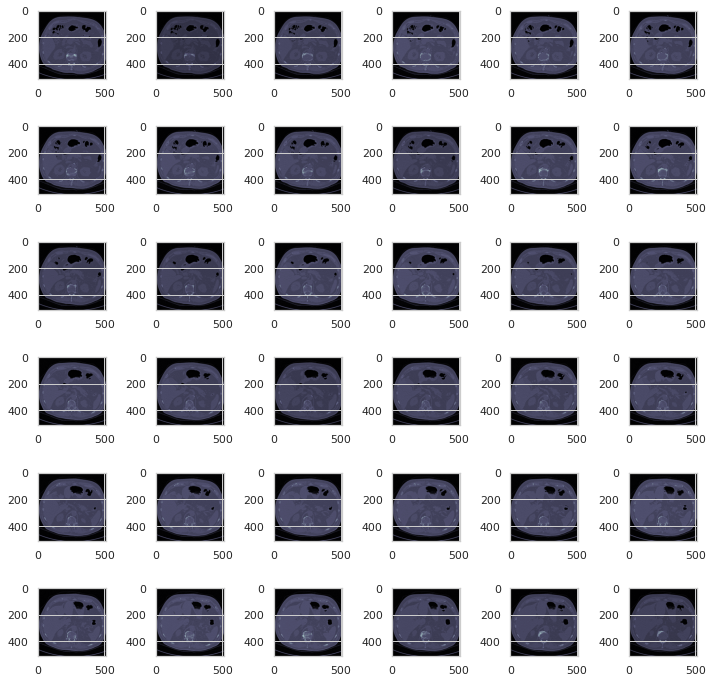

In [9]:
image_dir = '/content/drive/My Drive/OSIC Pulmonary Fibrosis/training/ID00007637202177411956430'

fig=plt.figure(figsize=(10,10))
columns = 6
rows = 6
image_list = os.listdir(image_dir)
for i in range(1, columns*rows +1):    
    fig.add_subplot(rows, columns, i)
    plt.imshow(first_patient_pixels[i], cmap=plt.cm.bone)
    plt.tight_layout()

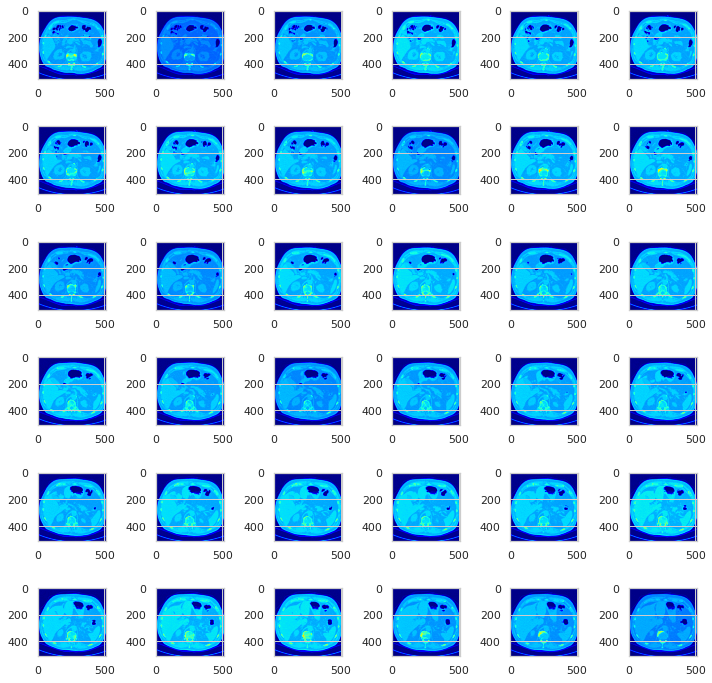

In [10]:
image_dir = '/content/drive/My Drive/OSIC Pulmonary Fibrosis/training/ID00007637202177411956430'

fig=plt.figure(figsize=(10,10))
columns = 6
rows = 6
image_list = os.listdir(image_dir)
for i in range(1, columns*rows +1):    
    fig.add_subplot(rows, columns, i)
    plt.imshow(first_patient_pixels[i], cmap='jet')
    plt.tight_layout()

# Masking

In [11]:
import pickle
DATA_PATH = "/content/drive/My Drive/dicom_meta_data.pkl"
infile = open(DATA_PATH,'rb')
meta_df = pickle.load(infile)
meta_df.head()

,Patient,body_part_examined,image_position_patient,image_orientation_patient,photometric_interpretation,rows,columns,pixel_spacing,window_center,window_width,modality,StudyInstanceUID,SeriesInstanceUID,StudyID,SamplesPerPixel,BitsAllocated,BitsStored,HighBit,PixelRepresentation,RescaleIntercept,RescaleSlope,img_min,img_max,img_mean,img_std
0,ID00423637202312137826377,Chest,"[-188.5, -56.5, 984.300049]","[1, 0, 0, 0, 1, 0]",MONOCHROME2,512,512,"[0.693359375, 0.693359375]",-500.0,-1500.0,CT,2.25.6467547893362082811063392930232473743,2.25.6467547893362082811063392930232473743,2.25.6467547893362082811063392930232473743,1,16,12,11,0,-1024.0,1.0,0,3348,518.435173,510.036957
1,ID00423637202312137826377,Chest,"[-188.5, -56.5, 986.300049]","[1, 0, 0, 0, 1, 0]",MONOCHROME2,512,512,"[0.693359375, 0.693359375]",-500.0,-1500.0,CT,2.25.6467547893362082811063392930232473743,2.25.6467547893362082811063392930232473743,2.25.6467547893362082811063392930232473743,1,16,12,11,0,-1024.0,1.0,0,3271,517.282322,508.945019
2,ID00423637202312137826377,Chest,"[-188.5, -56.5, 985.300049]","[1, 0, 0, 0, 1, 0]",MONOCHROME2,512,512,"[0.693359375, 0.693359375]",-500.0,-1500.0,CT,2.25.6467547893362082811063392930232473743,2.25.6467547893362082811063392930232473743,2.25.6467547893362082811063392930232473743,1,16,12,11,0,-1024.0,1.0,0,3245,517.906448,509.793827
3,ID00423637202312137826377,Chest,"[-188.5, -56.5, 983.300049]","[1, 0, 0, 0, 1, 0]",MONOCHROME2,512,512,"[0.693359375, 0.693359375]",-500.0,-1500.0,CT,2.25.6467547893362082811063392930232473743,2.25.6467547893362082811063392930232473743,2.25.6467547893362082811063392930232473743,1,16,12,11,0,-1024.0,1.0,0,3226,519.452381,509.732317
4,ID00423637202312137826377,Chest,"[-188.5, -56.5, 979.300049]","[1, 0, 0, 0, 1, 0]",MONOCHROME2,512,512,"[0.693359375, 0.693359375]",-500.0,-1500.0,CT,2.25.6467547893362082811063392930232473743,2.25.6467547893362082811063392930232473743,2.25.6467547893362082811063392930232473743,1,16,12,11,0,-1024.0,1.0,0,3168,523.377628,511.021599


In [12]:
#we have 176 unique patients
df_train.Patient.value_counts()

ID00099637202206203080121    10
ID00388637202301028491611    10
ID00400637202305055099402    10
ID00140637202231728595149    10
ID00343637202287577133798    10
                             ..
ID00111637202210956877205     7
ID00052637202186188008618     7
ID00186637202242472088675     7
ID00047637202184938901501     6
ID00267637202270790561585     6
Name: Patient, Length: 176, dtype: int64

In [13]:
#we have 173 unique patients, dmc of 3patients' images lack some attributes 
meta_df.Patient.value_counts()

ID00078637202199415319443    1018
ID00202637202249376026949     825
ID00173637202238329754031     602
ID00180637202240177410333     577
ID00035637202182204917484     574
                             ... 
ID00214637202257820847190      18
ID00229637202260254240583      17
ID00126637202218610655908      17
ID00248637202266698862378      16
ID00165637202237320314458      12
Name: Patient, Length: 173, dtype: int64

In [14]:
train=df_train.drop_duplicates(subset='Patient',keep="first")
meta=meta_df.drop_duplicates(subset='Patient', keep='first')

In [15]:
data=train.merge(meta, on='Patient', how='left')

In [16]:
data.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus,Path,dcm count,body_part_examined,image_position_patient,image_orientation_patient,photometric_interpretation,rows,columns,pixel_spacing,window_center,window_width,modality,StudyInstanceUID,SeriesInstanceUID,StudyID,SamplesPerPixel,BitsAllocated,BitsStored,HighBit,PixelRepresentation,RescaleIntercept,RescaleSlope,img_min,img_max,img_mean,img_std
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker,/content/drive/My Drive/OSIC Pulmonary Fibrosi...,30,Chest,"[-158.700, -153.500, -69.750]","[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",MONOCHROME2,512.0,512.0,"[0.652344, 0.652344]",-500.0,-1500.0,CT,2.25.80896671862726099888461805953012988790,2.25.80896671862726099888461805953012988790,2.25.80896671862726099888461805953012988790,1.0,16.0,16.0,15.0,1.0,-1024.0,1.0,-2000.0,2842.0,-1.454884,1137.488858
1,ID00009637202177434476278,8,3660,85.282878,69,Male,Ex-smoker,/content/drive/My Drive/OSIC Pulmonary Fibrosi...,394,Chest,"[-171.634766, -333.634766, -44.200001]","[1.000000, 0.000000, 0.000000, 0.000000, 1.000...",MONOCHROME2,768.0,768.0,"[0.486979, 0.486979]",-500.0,1500.0,CT,2.25.156962683457839326089809785890930019885,2.25.156962683457839326089809785890930019885,2.25.156962683457839326089809785890930019885,1.0,16.0,16.0,15.0,0.0,-1024.0,1.0,0.0,4346.0,591.064126,568.077568
2,ID00010637202177584971671,0,3523,94.724672,60,Male,Ex-smoker,/content/drive/My Drive/OSIC Pulmonary Fibrosi...,106,Chest,"[-169.1728515625, -314.1728515625, -798.5]","[1, 0, 0, 0, 1, 0]",MONOCHROME2,512.0,512.0,"[0.654296875, 0.654296875]",-500.0,-1500.0,CT,2.25.11726522219678615199208148726917028045,2.25.11726522219678615199208148726917028045,2.25.11726522219678615199208148726917028045,1.0,16.0,12.0,11.0,0.0,-1024.0,1.0,0.0,3135.0,522.350807,535.789915
3,ID00011637202177653955184,6,3326,85.987590,72,Male,Ex-smoker,/content/drive/My Drive/OSIC Pulmonary Fibrosi...,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ID00012637202177665765362,33,3418,93.726006,65,Male,Never smoked,/content/drive/My Drive/OSIC Pulmonary Fibrosi...,49,Chest,"[-160.0000, -160.0000, 1909.000]","[1.00000, 0.00000, 0.00000, 0.00000, 1.00000, ...",MONOCHROME2,512.0,512.0,"[0.625, 0.625]",-500.0,-1500.0,CT,2.25.153147783572292318044190524202375230808,2.25.153147783572292318044190524202375230808,2.25.153147783572292318044190524202375230808,1.0,16.0,16.0,15.0,1.0,0.0,1.0,-2048.0,2647.0,-743.294075,828.525457


In [17]:
print("Q: Are there any missing values?", "\n" +
      "A: {}".format(data.isnull().values.any()))

Q: Are there any missing values? 
A: True


In [18]:
data.isnull().sum()

Patient                       0
Weeks                         0
FVC                           0
Percent                       0
Age                           0
Sex                           0
SmokingStatus                 0
Path                          0
dcm count                     0
body_part_examined            3
image_position_patient        3
image_orientation_patient     3
photometric_interpretation    3
rows                          3
columns                       3
pixel_spacing                 3
window_center                 3
window_width                  3
modality                      3
StudyInstanceUID              3
SeriesInstanceUID             3
StudyID                       3
SamplesPerPixel               3
BitsAllocated                 3
BitsStored                    3
HighBit                       3
PixelRepresentation           3
RescaleIntercept              3
RescaleSlope                  3
img_min                       3
img_max                       3
img_mean

In [19]:
data.dropna(axis=0, inplace=True)

In [20]:
print("Q: any missing values?", "\n" +
      "A: {}".format(data.isnull().values.any()))

Q: any missing values? 
A: False
